# Обучение с учителем: качество модели

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

**Подход к решению задачи:**
1. Нужно промаркировать уровень финансовой активности постоянных покупателей. В компании принято выделять два уровня активности: «снизилась», если клиент стал покупать меньше товаров, и «прежний уровень».

2. Нужно собрать данные по клиентам по следующим группам:
    - Признаки, которые описывают коммуникацию сотрудников компании с клиентом.
    - Признаки, которые описывают продуктовое поведение покупателя. Например, какие товары покупает и как часто.
    - Признаки, которые описывают покупательское поведение клиента. Например, сколько тратил в магазине.
    - Признаки, которые описывают поведение покупателя на сайте. Например, как много страниц просматривает и сколько времени проводит на сайте.

Группы признаков (вместе с целевым) представлены в виде диаграммы:

<img src='https://pictures.s3.yandex.net/resources/image_1695485033.png' width=1900, unconfined=True>

1. Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
2. В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
3. Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

**Описание данных**

1. Файл `market_file.csv`  содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении:
    * `id` — номер покупателя в корпоративной базе данных.
    * `Покупательская активность` — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
    * `Тип сервиса` — уровень сервиса, например «премиум» и «стандарт».
    * `Разрешить сообщать` — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
    * `Маркет_актив_6_мес` — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
    * `Длительность` - значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
    * `Маркет_актив_тек_мес` — количество маркетинговых коммуникаций в текущем месяце.
    * `Акционные_покупки` — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
    * `Популярная_категория` — самая популярная категория товаров у покупателя за последние 6 месяцев.
    * `Средний_просмотр_категорий_за_визит` — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
    * `Неоплаченные_продукты_штук_квартал` — общее число неоплаченных товаров в корзине за последние 3 месяца.
    * `Ошибка_сервиса` — число сбоев, которые коснулись покупателя во время посещения сайта.
    * `Страниц_за_визит` — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

2. Файл `market_money.csv`  содержит данные о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом:
    * `id` — номер покупателя в корпоративной базе данных.
    * `Период` — название периода, во время которого зафиксирована выручка. Например, `текущий_месяц` или `предыдущий_месяц`.
    * `Выручка` — сумма выручки за период.

3. Файл `market_time.csv`  содержит данные о времени (в минутах), которое покупатель провёл на сайте в течение периода:
    * `id` — номер покупателя в корпоративной базе данных.
    * `Период` — название периода, во время которого зафиксировано общее время.
    * `минут` — значение времени, проведённого на сайте, в минутах.

4. Файл `money.csv` о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю:
    * `id` — номер покупателя в корпоративной базе данных.
    * `Прибыль` — значение прибыли.

In [1]:
! pip install scikit-learn==0.24.1 -q

In [2]:
import sklearn
sklearn.__version__

'0.24.1'

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC 
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score

## Загрузка данных и общая информация

In [2]:
try:
    market_file_df = pd.read_csv('https://code.s3.yandex.net/datasets/market_file.csv')
    market_money_df = pd.read_csv('https://code.s3.yandex.net/datasets/market_money.csv')
    market_time_df = pd.read_csv('https://code.s3.yandex.net/datasets/market_time.csv')
    money_df = pd.read_csv('https://code.s3.yandex.net/datasets/money.csv', sep=';', decimal=',')
except:
    print("Загрузка файлов не удалась!")


In [3]:
display(market_file_df.head(10))
print('-----------------------')
market_file_df.info()

id Покупательская активность Тип сервиса Разрешить сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась   стандартт                нет   
3  215351                 Снизилась   стандартт                 да   
4  215352                 Снизилась   стандартт                нет   
5  215353                 Снизилась   стандартт                 да   
6  215354                 Снизилась   стандартт                 да   
7  215355                 Снизилась   стандартт                нет   
8  215356                 Снизилась   стандартт                 да   
9  215357                 Снизилась   стандартт                 да   

   Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   
5                 3.3                     4           762               0.26   
6                 5.1                     3           431               0.23   
7                 4.7                     4           284               0.17   
8                 4.2                     4           192               0.14   
9                 3.9                     5           154               0.00   

             Популярная_категория  Средний_просмотр_категорий_за_визит  \
0                Товары для детей                                    6   
1                Товары для детей                                    4   
2               Домашний текстиль                                    5   
3                Товары для детей                                    5   
4                Товары для детей                                    3   
5               Домашний текстиль                                    4   
6           Косметика и аксесуары                                    2   
7                Товары для детей                                    5   
8           Косметика и аксесуары                                    2   
9  Техника для красоты и здоровья                                    3   

   Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  
0                                   2               1                 5  
1                                   4               2                 5  
2                                   2               1                 5  
3                                   0               6                 4  
4                                   2               3                 2  
5                                   1               1                 4  
6                                   3               7                 2  
7                                   1               6                 4  
8                                   2               1                 3  
9                                   3               9                 5

-----------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка

Пропущенных значений в `market_file_df` нет. Столбцы имеют соответствующий тип данных.

In [4]:
display(market_money_df.head(10))
print('-----------------------')
market_money_df.info()

id               Период  Выручка
0  215348  препредыдущий_месяц      0.0
1  215348        текущий_месяц   3293.1
2  215348     предыдущий_месяц      0.0
3  215349  препредыдущий_месяц   4472.0
4  215349        текущий_месяц   4971.6
5  215349     предыдущий_месяц   5216.0
6  215350  препредыдущий_месяц   4826.0
7  215350        текущий_месяц   5058.4
8  215350     предыдущий_месяц   5457.5
9  215351        текущий_месяц   6610.4

-----------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


Пропущенных значений в `market_money_df` нет. Столбцы имеют соответствующий тип данных.

In [5]:
display(market_time_df.head(10))
print('-----------------------')
market_time_df.info()

id            Период  минут
0  215348     текущий_месяц     14
1  215348  предыдцщий_месяц     13
2  215349     текущий_месяц     10
3  215349  предыдцщий_месяц     12
4  215350     текущий_месяц     13
5  215350  предыдцщий_месяц      8
6  215351     текущий_месяц     13
7  215351  предыдцщий_месяц     11
8  215352     текущий_месяц     11
9  215352  предыдцщий_месяц      8

-----------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


Пропущенных значений в `market_time_df` нет. Столбцы имеют соответствующий тип данных.

In [6]:
display(money_df.head(10))
print('-----------------------')
money_df.info()

id  Прибыль
0  215348     0.98
1  215349     4.16
2  215350     3.13
3  215351     4.87
4  215352     4.21
5  215353     3.95
6  215354     3.62
7  215355     5.26
8  215356     4.93
9  215357     4.66

-----------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


Пропущенных значений в `money_df` нет. Столбец имеет соответствующий тип данных.

## Предобработка данных

### Приведение названий столбцов к однообразному регистру ("змеинному")

In [7]:
market_file_df.columns = market_file_df.columns.str.lower().str.replace(' ', '_')
market_money_df.columns = market_money_df.columns.str.lower().str.replace(' ', '_')
market_time_df.columns = market_time_df.columns.str.lower().str.replace(' ', '_')
money_df.columns = money_df.columns.str.lower().str.replace(' ', '_')

### Поиск и устранение дубликатов

#### Поиск явных дубликатов

In [8]:
print(f'Кол-во явных дубликатов в "market_file_df": {market_file_df.duplicated().sum()}')
print(f'Кол-во явных дубликатов в "market_money_df": {market_money_df.duplicated().sum()}')
print(f'Кол-во явных дубликатов в "market_time_df": {market_time_df.duplicated().sum()}')
print(f'Кол-во явных дубликатов в "money_df": {money_df.duplicated().sum()}')

Кол-во явных дубликатов в "market_file_df": 0
Кол-во явных дубликатов в "market_money_df": 0
Кол-во явных дубликатов в "market_time_df": 0
Кол-во явных дубликатов в "money_df": 0


Явных дубликатов не найдено ни в одном из датафремов.

#### Поиск неявных дубликатов

In [9]:
for column in market_file_df.columns:
    if market_file_df[column].dtype == 'object': 
        print(f'Поиск неявных дубликатов для столбца {column}:')
        print(market_file_df[column].value_counts())
        print('-----------------------')

Поиск неявных дубликатов для столбца покупательская_активность:
Прежний уровень    802
Снизилась          498
Name: покупательская_активность, dtype: int64
-----------------------
Поиск неявных дубликатов для столбца тип_сервиса:
стандарт     914
премиум      376
стандартт     10
Name: тип_сервиса, dtype: int64
-----------------------
Поиск неявных дубликатов для столбца разрешить_сообщать:
да     962
нет    338
Name: разрешить_сообщать, dtype: int64
-----------------------
Поиск неявных дубликатов для столбца популярная_категория:
Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: популярная_категория, dtype: int64
-----------------------


Устраним 10 найденных неявных дубликатов в столбце `тип_сервиса` датафрейма `market_file_df`:

In [10]:
market_file_df = market_file_df.replace(['стандартт'], ['стандарт'])

In [11]:
for column in market_money_df.columns:
    if market_money_df[column].dtype == 'object': 
        print(f'Поиск неявных дубликатов для столбца {column}:')
        print(market_money_df[column].value_counts())
        print('-----------------------')

Поиск неявных дубликатов для столбца период:
препредыдущий_месяц    1300
текущий_месяц          1300
предыдущий_месяц       1300
Name: период, dtype: int64
-----------------------


Неявных дубликатов в датафрейме `market_money_df` не найдено.

In [12]:
for column in market_time_df.columns:
    if market_time_df[column].dtype == 'object': 
        print(f'Поиск неявных дубликатов для столбца {column}:')
        print(market_time_df[column].value_counts())
        print('-----------------------')

Поиск неявных дубликатов для столбца период:
предыдцщий_месяц    1300
текущий_месяц       1300
Name: период, dtype: int64
-----------------------


Неявных дубликатов не найдено, однако значение `предыдцщий_месяц` целесообразно заменить на `предыдущий_месяц`:

In [13]:
market_time_df = market_time_df.replace(['предыдцщий_месяц'], ['предыдущий_месяц'])

## Исследовательский анализ данных

In [14]:
# Функция для построения boxplot и hist (для числовых признаков)
def box_hist_plot(df, column, bins, plot_name):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    df.boxplot(column=column, ax=axes[0])
    axes[0].set_title('Boxplot')
    axes[0].tick_params(axis='x', labelbottom=False)
    axes[0].set_ylabel(column)

    df[column].hist(bins=bins, ax=axes[1])
    axes[1].set_title('Histogram')
    axes[1].set_xlabel(column)

    fig.suptitle(plot_name, y=1.05)

    display(df[column].describe())
    IQR = df[column].describe()['75%'] - df[column].describe()['25%']
    Q1_minus = df[column].describe()['25%'] - 1.5 * IQR
    Q3_plus = df[column].describe()['75%'] + 1.5 * IQR
    
    print(f"Усы боксплота: ({Q1_minus}, {Q3_plus})")

# Функция для построения pie chart (для категориальных признаков)
def pie_chart(df, column, plot_name):

    allvals_sum = df.shape[0] 
    dt_temp = df.pivot_table(index=column, aggfunc='count')
    dt = dt_temp[dt_temp.columns[0]] 
    dt_legend = df.pivot_table(index=column, aggfunc='count').reset_index()[column].tolist()
    
    def func(pct):
        absolute = float(pct/100.*allvals_sum)
        return "{:.1f}%\n({:.0f})".format(pct, absolute)

    fig, ax = plt.subplots(figsize=(12, 5), subplot_kw=dict(aspect="equal"))

    wedges, texts, autotexts = ax.pie(dt, autopct=lambda pct: func(pct), textprops=dict(color="w"))

    ax.legend(wedges, dt_legend,
            # title="",
            loc="center left",
            bbox_to_anchor=(1, 0, 0.5, 1))

    plt.setp(autotexts, size = 8, weight ="bold")
    ax.set_title(plot_name)

    # show plot
    plt.show()

### Исследование числовых признаков для `market_file_df`

count    1300.000000
mean        4.253769
std         1.014814
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: маркет_актив_6_мес, dtype: float64

Усы боксплота: (1.9, 6.700000000000001)


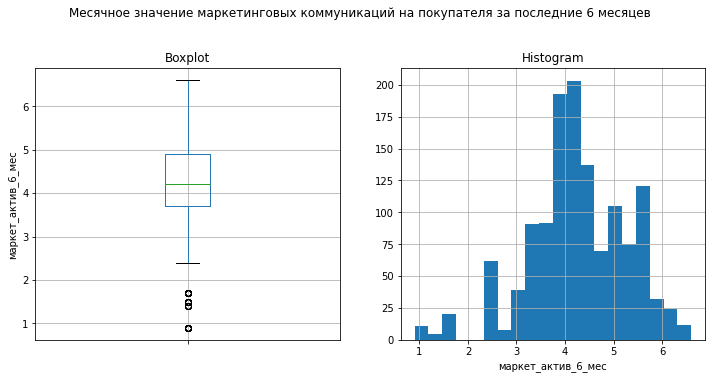

In [15]:
box_hist_plot(market_file_df, 'маркет_актив_6_мес', 20, 'Месячное значение маркетинговых коммуникаций на покупателя за последние 6 месяцев')

Для параметра `маркет_актив_6_мес` обнаружено небольшле кол-во выбросов.

count    1300.000000
mean      601.898462
std       249.856289
min       110.000000
25%       405.500000
50%       606.000000
75%       806.000000
max      1079.000000
Name: длительность, dtype: float64

Усы боксплота: (-195.25, 1406.75)


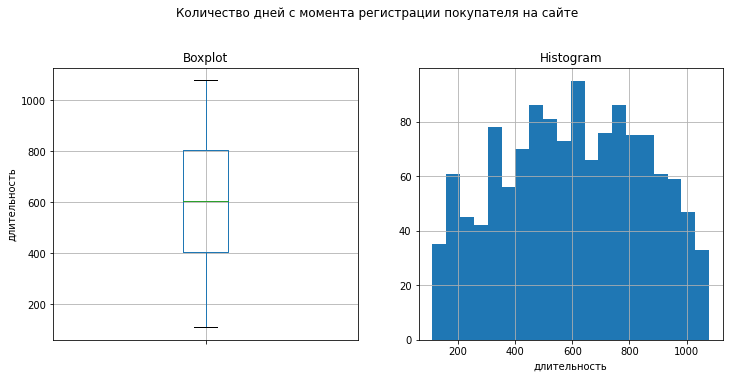

In [16]:
box_hist_plot(market_file_df, 'длительность', 20, 'Количество дней с момента регистрации покупателя на сайте')

Выбросов для параметра `длительность` не обнаружено.

count    1300.000000
mean        0.319808
std         0.249843
min         0.000000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: акционные_покупки, dtype: float64

Усы боксплота: (-0.02499999999999994, 0.49499999999999994)


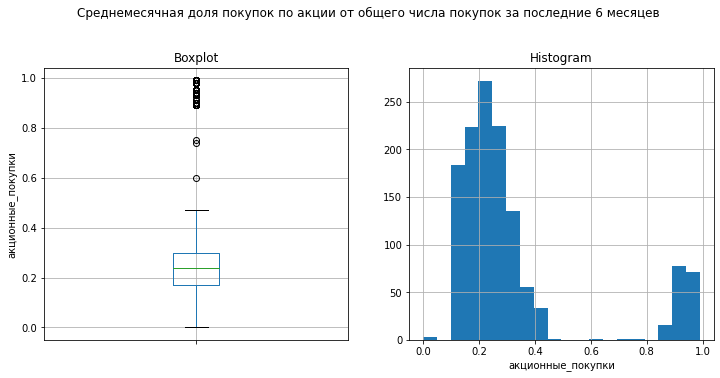

In [17]:
box_hist_plot(market_file_df, 'акционные_покупки', 20, 'Среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев')

Для параметра `акционные_покупки` обнаружены выбросы.

count    1300.00000
mean        3.27000
std         1.35535
min         1.00000
25%         2.00000
50%         3.00000
75%         4.00000
max         6.00000
Name: средний_просмотр_категорий_за_визит, dtype: float64

Усы боксплота: (-1.0, 7.0)


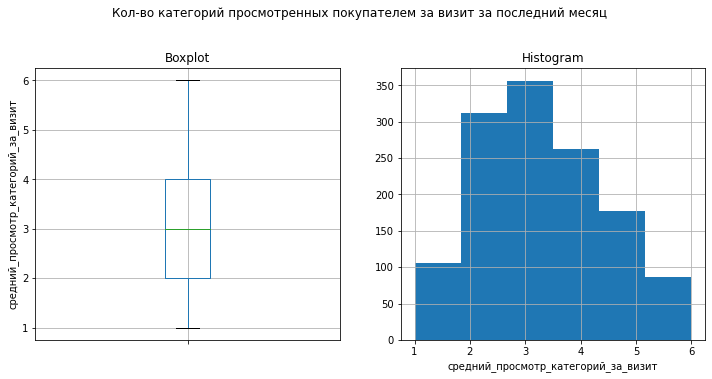

In [18]:
box_hist_plot(market_file_df, 'средний_просмотр_категорий_за_визит', 6, 'Кол-во категорий просмотренных покупателем за визит за последний месяц')

Для параметра `средний_просмотр_категорий_за_визит` выбросы не обнаружены.

count    1300.000000
mean        2.840000
std         1.971451
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: неоплаченные_продукты_штук_квартал, dtype: float64

Усы боксплота: (-3.5, 8.5)


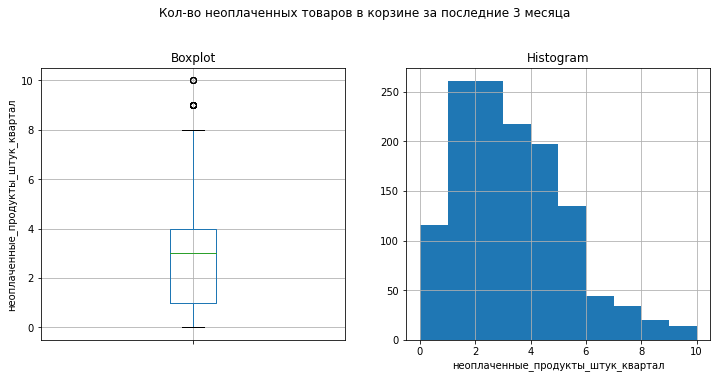

In [19]:
box_hist_plot(market_file_df, 'неоплаченные_продукты_штук_квартал', 10, 'Кол-во неоплаченных товаров в корзине за последние 3 месяца')

Для параметра `неоплаченные_продукты_штук_квартал` обнаружено небольшое кол-во выбросов.

count    1300.000000
mean        4.185385
std         1.955298
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max         9.000000
Name: ошибка_сервиса, dtype: float64

Усы боксплота: (-1.5, 10.5)


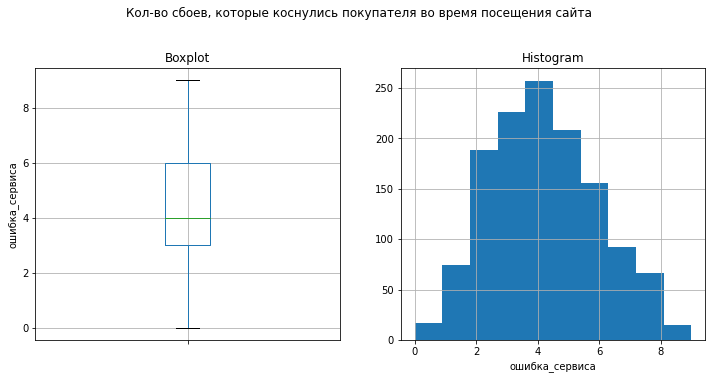

In [20]:
box_hist_plot(market_file_df, 'ошибка_сервиса', 10, 'Кол-во сбоев, которые коснулись покупателя во время посещения сайта')

Для параметра `ошибка_сервиса` выбросы не обнаружены.

count    1300.000000
mean        8.176923
std         3.978126
min         1.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        20.000000
Name: страниц_за_визит, dtype: float64

Усы боксплота: (-4.0, 20.0)


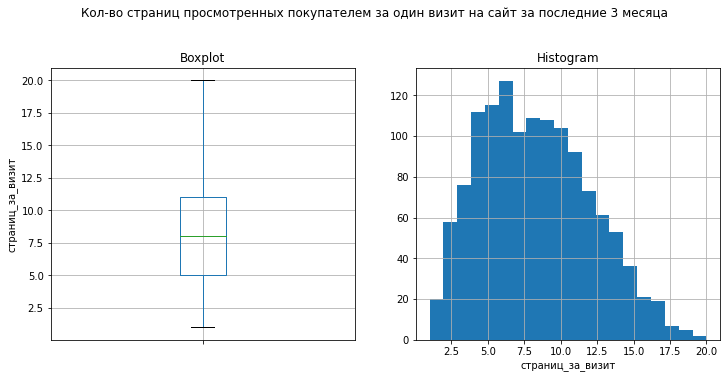

In [21]:
box_hist_plot(market_file_df, 'страниц_за_визит', 20, 'Кол-во страниц просмотренных покупателем за один визит на сайт за последние 3 месяца')

### Исследование категориальных признаков для `market_file_df`

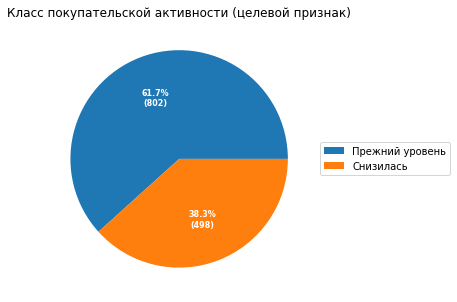

In [22]:
pie_chart(market_file_df, 'покупательская_активность', 'Класс покупательской активности (целевой признак)')

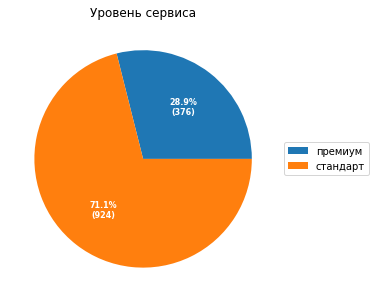

In [23]:
pie_chart(market_file_df, 'тип_сервиса', 'Уровень сервиса')

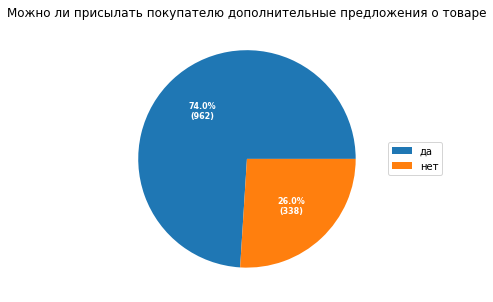

In [24]:
pie_chart(market_file_df, 'разрешить_сообщать', 'Можно ли присылать покупателю дополнительные предложения о товаре')

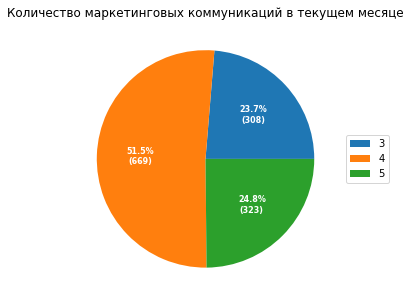

In [25]:
pie_chart(market_file_df, 'маркет_актив_тек_мес', 'Количество маркетинговых коммуникаций в текущем месяце')

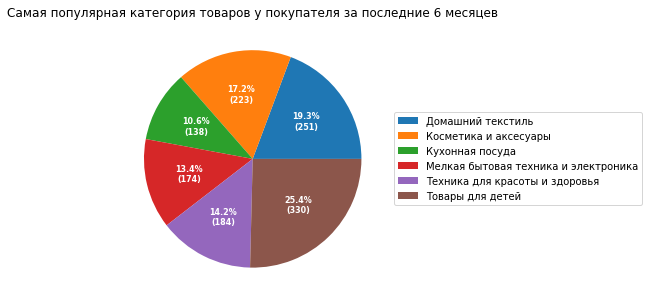

In [26]:
pie_chart(market_file_df, 'популярная_категория', 'Самая популярная категория товаров у покупателя за последние 6 месяцев')

**Вывод:** Распределения числовых признаков датафрейма `market_file_df` не имеют явно выраженного нормального распределения. У признаков `маркет_актив_6_мес`, `акционные_покупки`, `неоплаченные_продукты_штук_квартал` присутствуют аномалии. Для категориальных признаков определено следующее:
для таргета `покупательская_активность` 62% значений составляют класс `прежний уровень`, а оставшиеся 32% `снизилась` - здесь наблюдается некоторый дисбаланс, который нужно будет учесть в дальнейшем; большинство покупателей (71%) имеет тип сервиса `стандарт`, согласны на рассылку доп. приложений о товаре (74%) и получали 4 уведомления (маркетинговых коммуникаций) от компании (51%). Наиболее популярными товарами оказались товары категории `для детей` (25%), `домашний текстиль` (19%) и `косметика и аксесуары` (17,2%).

### Исследование признаков для `market_money_df`

count      3900.000000
mean       5025.696051
std        1777.704104
min           0.000000
25%        4590.150000
50%        4957.500000
75%        5363.000000
max      106862.200000
Name: выручка, dtype: float64

Усы боксплота: (3430.874999999999, 6522.275000000001)


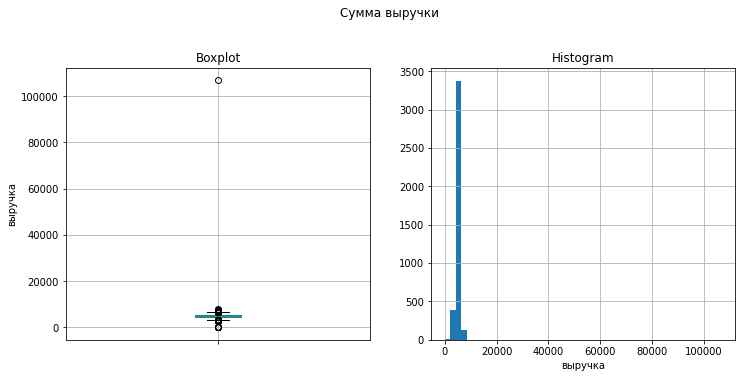

In [27]:
box_hist_plot(market_money_df, 'выручка', 50, 'Cумма выручки')

На боксплоте наблюдется явный выброс со значением в 22 раза превышающее среднее. Удалим его и перестроим графики:

count    3899.00000
mean     4999.57743
std       706.99988
min         0.00000
25%      4590.10000
50%      4957.00000
75%      5363.00000
max      7799.40000
Name: выручка, dtype: float64

Усы боксплота: (3430.750000000001, 6522.349999999999)


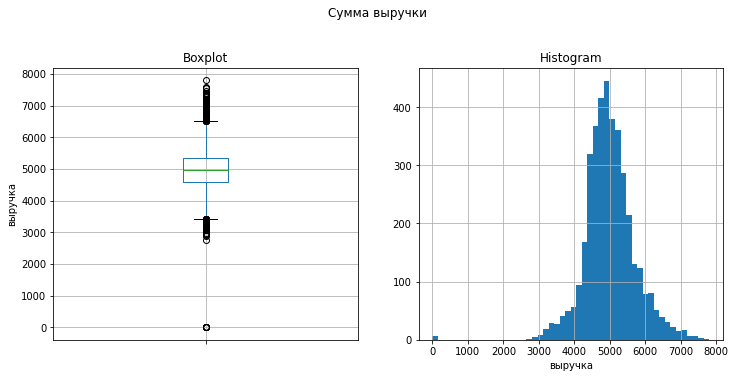

In [28]:
market_money_df = market_money_df.query('выручка != 106862.2')
box_hist_plot(market_money_df, 'выручка', 50, 'Cумма выручки')

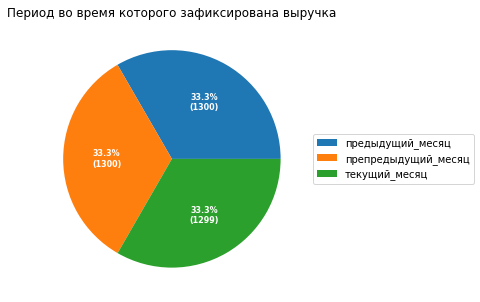

In [29]:
pie_chart(market_money_df, 'период', 'Период во время которого зафиксирована выручка')

**Вывод:** Для признака `выручка` наблюдается значительное кол-во аномальных значений, однако в основном они сгруппированы у "усов" боксплота, наиболее же отдаленными оказались аномальные значения равные 0. Распределение признака близко к нормальному. Из диаграммы `Период во время которого зафиксирована выручка` видно, что покупатели финансовая активность одинакова за все 3 месяца.  

### Исследование признаков для `market_time_df` и `money_df`

count    2600.000000
mean       13.336154
std         4.080198
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: минут, dtype: float64

Усы боксплота: (1.0, 25.0)


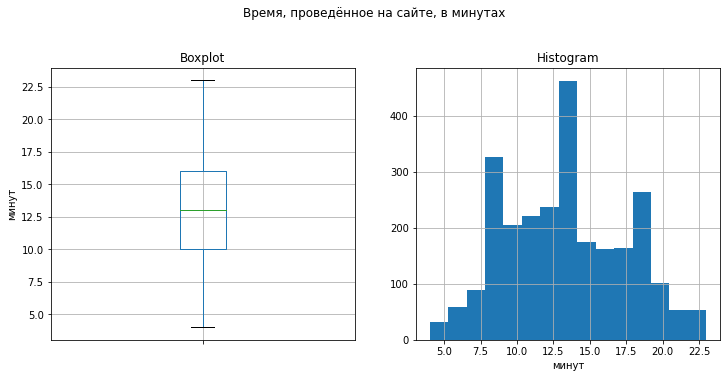

In [30]:
box_hist_plot(market_time_df, 'минут', 15, 'Время, проведённое на сайте, в минутах')

**Вывод:** Для признака `минут` не наблюдается выбросов. Распределение признака не имеет явно выраженного нормального распределения.

count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: прибыль, dtype: float64

Усы боксплота: (1.2449999999999997, 6.725)


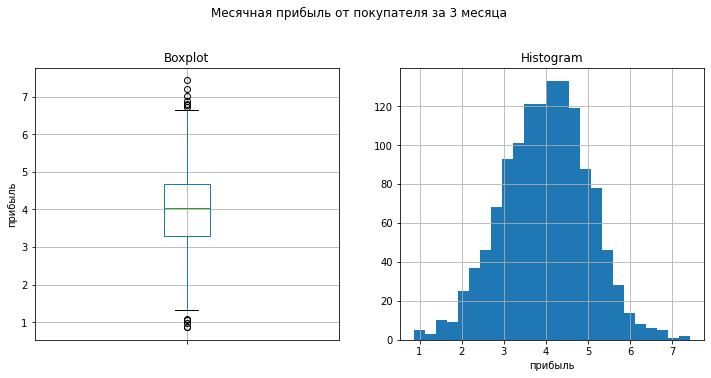

In [31]:
box_hist_plot(money_df, 'прибыль', 25, 'Месячная прибыль от покупателя за 3 месяца')

**Вывод:** Для признака `прибыль` наблюдаются выбросы, сгруппированные у "усов" боксплота. Распределение имеет вид нормального.

### Сравнительное исследования признаков с и без снижения покупательской активности для `market_file_df`

In [32]:
# Функция для сравнительного исследования гистограмм и боксплотов
def box_hist_plot_сompare(df, column, bins, plot_name):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    # Разделение на категории
    category_1_data = df[df['покупательская_активность'] == 'Снизилась'][column]
    category_2_data = df[df['покупательская_активность'] == 'Прежний уровень'][column]

    # Boxplot
    axes[0].boxplot([category_1_data, category_2_data], labels=['Снизилась', 'Прежний уровень'])
    axes[0].set_title('Boxplot')
    axes[0].set_ylabel(column)

    # Histogram
    axes[1].hist([category_1_data, category_2_data], bins=bins, label=['Снизилась', 'Прежний уровень'], histtype="step")
    axes[1].set_title('Histogram')
    axes[1].set_xlabel(column)
    axes[1].legend()

    fig.suptitle(plot_name, y=1.05)

    # Display descriptive statistics
    display(df.groupby('покупательская_активность')[column].describe())
    
    # Calculate and display the whiskers range
    for category in ['Снизилась', 'Прежний уровень']:
        category_data = df[df['покупательская_активность'] == category][column]
        IQR = category_data.describe()['75%'] - category_data.describe()['25%']
        Q1_minus = category_data.describe()['25%'] - 1.5 * IQR
        Q3_plus = category_data.describe()['75%'] + 1.5 * IQR
        print(f"Усы боксплота для категории '{category}': ({Q1_minus}, {Q3_plus})")


# Функция для сравнительного исследования категориальных признаков
def pie_chart_compare(df, column, plot_name):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    for i, category in enumerate(['Снизилась', 'Прежний уровень']):
        category_data = df[df['покупательская_активность'] == category][column]
        dt_temp = category_data.value_counts()
        dt_legend = dt_temp.index.tolist()

        def func(pct):
            absolute = float(pct / 100. * len(category_data))
            return "{:.1f}%\n({:.0f})".format(pct, absolute)

        wedges, texts, autotexts = axes[i].pie(dt_temp, autopct=lambda pct: func(pct), textprops=dict(color="w"))

        axes[i].legend(wedges, dt_legend, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
        plt.setp(autotexts, size=8, weight="bold")
        axes[i].set_title(f'{category} - {plot_name}')

    plt.tight_layout()
    plt.show()

count      mean       std  min  25%  50%    75%  \
покупательская_активность                                                    
Прежний уровень            802.0  4.570075  0.848618  0.9  4.0  4.4  5.275   
Снизилась                  498.0  3.744378  1.053374  0.9  3.1  3.9  4.400   

                           max  
покупательская_активность       
Прежний уровень            6.6  
Снизилась                  6.6

Усы боксплота для категории 'Снизилась': (1.1499999999999997, 6.3500000000000005)
Усы боксплота для категории 'Прежний уровень': (2.0874999999999995, 7.187500000000001)


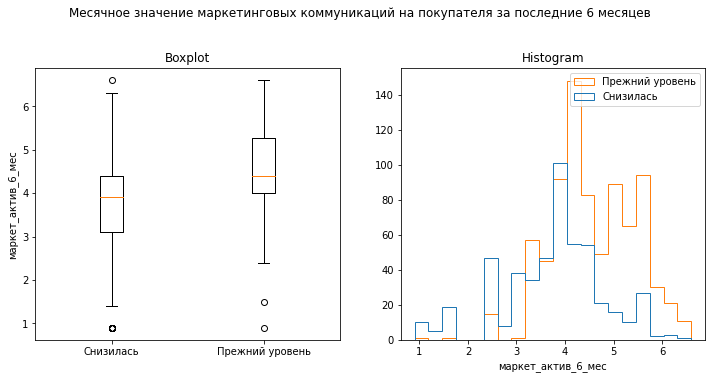

In [33]:
box_hist_plot_сompare(market_file_df, 'маркет_актив_6_мес', 20, 'Месячное значение маркетинговых коммуникаций на покупателя за последние 6 месяцев')

Из графиков видно, что у клиентов со снижающейся активностью месячное значение маркетинговых коммуникаций меньше. 

count        mean         std    min    25%    50%  \
покупательская_активность                                                       
Прежний уровень            802.0  590.730673  255.330179  121.0  382.5  590.0   
Снизилась                  498.0  619.883534  239.940818  110.0  449.0  634.5   

                              75%     max  
покупательская_активность                  
Прежний уровень            798.75  1061.0  
Снизилась                  811.00  1079.0

Усы боксплота для категории 'Снизилась': (-94.0, 1354.0)
Усы боксплота для категории 'Прежний уровень': (-241.875, 1423.125)


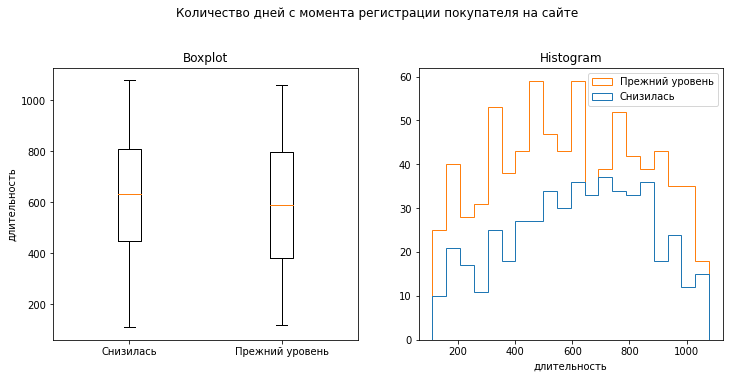

In [34]:
box_hist_plot_сompare(market_file_df, 'длительность', 20, 'Количество дней с момента регистрации покупателя на сайте')

Из графиков видно, что клиенты со снижающейся активностью имеют большее кол-во дней с момента регистрации.

count      mean       std   min   25%   50%   75%  \
покупательская_активность                                                      
Прежний уровень            802.0  0.238367  0.160599  0.11  0.15  0.21  0.26   
Снизилась                  498.0  0.450964  0.306011  0.00  0.24  0.31  0.89   

                            max  
покупательская_активность        
Прежний уровень            0.99  
Снизилась                  0.99

Усы боксплота для категории 'Снизилась': (-0.7350000000000001, 1.8650000000000002)
Усы боксплота для категории 'Прежний уровень': (-0.015000000000000041, 0.42500000000000004)


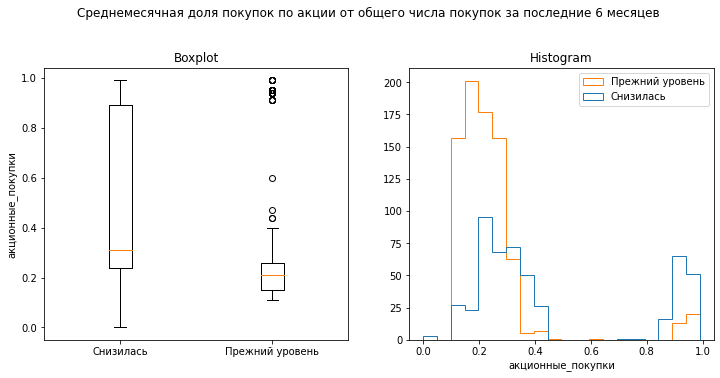

In [35]:
box_hist_plot_сompare(market_file_df, 'акционные_покупки', 20, 'Среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев')

Из графиков видно, что клиенты со снижающейся активностью имеют большую долю акционных покупок.

count      mean       std  min  25%  50%  75%  max
покупательская_активность                                                    
Прежний уровень            802.0  3.665835  1.277112  1.0  3.0  4.0  5.0  6.0
Снизилась                  498.0  2.632530  1.229871  1.0  2.0  2.0  3.0  6.0

Усы боксплота для категории 'Снизилась': (0.5, 4.5)
Усы боксплота для категории 'Прежний уровень': (0.0, 8.0)


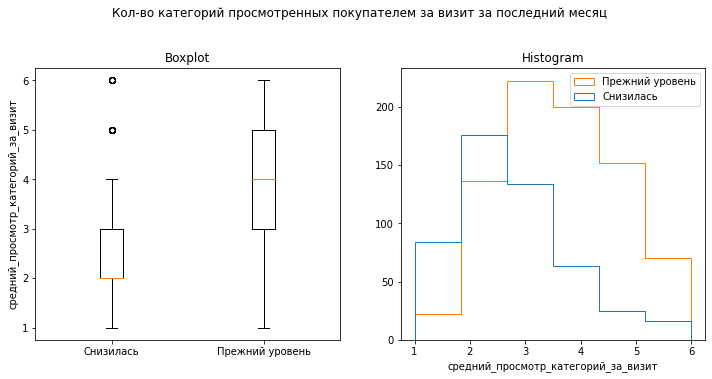

In [36]:
box_hist_plot_сompare(market_file_df, 'средний_просмотр_категорий_за_визит', 6, 'Кол-во категорий просмотренных покупателем за визит за последний месяц')

Из графиков видно, что клиенты со снижающейся активностью просматривают меньше категорий за визит.

count      mean       std  min  25%  50%  75%   max
покупательская_активность                                                     
Прежний уровень            802.0  2.293017  1.508255  0.0  1.0  2.0  3.0   8.0
Снизилась                  498.0  3.720884  2.287312  0.0  2.0  4.0  5.0  10.0

Усы боксплота для категории 'Снизилась': (-2.5, 9.5)
Усы боксплота для категории 'Прежний уровень': (-2.0, 6.0)


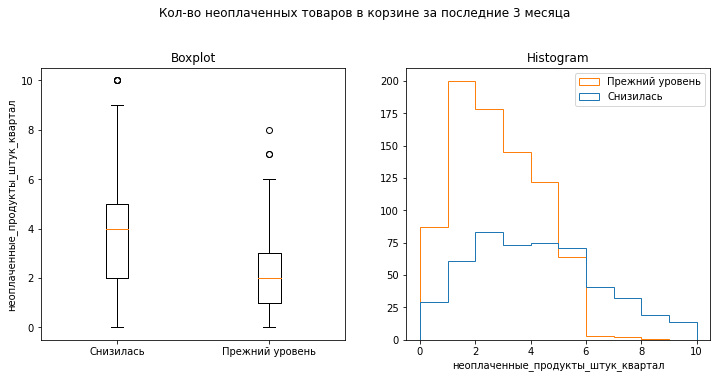

In [37]:
box_hist_plot_сompare(market_file_df, 'неоплаченные_продукты_штук_квартал', 10, 'Кол-во неоплаченных товаров в корзине за последние 3 месяца')

Из графиков видно, что клиенты со снижающейся активностью имеют большое кол-во неоплаченных товаров в корзине.

count      mean       std  min  25%  50%  75%  max
покупательская_активность                                                    
Прежний уровень            802.0  4.335411  1.979538  0.0  3.0  4.0  6.0  9.0
Снизилась                  498.0  3.943775  1.892709  1.0  2.0  4.0  5.0  9.0

Усы боксплота для категории 'Снизилась': (-2.5, 9.5)
Усы боксплота для категории 'Прежний уровень': (-1.5, 10.5)


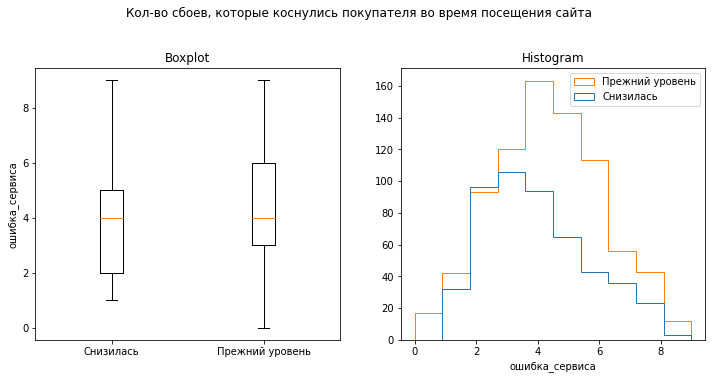

In [38]:
box_hist_plot_сompare(market_file_df, 'ошибка_сервиса', 10, 'Кол-во сбоев, которые коснулись покупателя во время посещения сайта')

Из графиков видно, что клиенты со снижающейся активностью имеют примерно сопоставимое с активными клиентами число сбоев.

count      mean       std  min  25%   50%   75%  \
покупательская_активность                                                    
Прежний уровень            802.0  9.796758  3.376846  3.0  7.0  10.0  12.0   
Снизилась                  498.0  5.568273  3.454265  1.0  3.0   5.0   7.0   

                            max  
покупательская_активность        
Прежний уровень            20.0  
Снизилась                  18.0

Усы боксплота для категории 'Снизилась': (-3.0, 13.0)
Усы боксплота для категории 'Прежний уровень': (-0.5, 19.5)


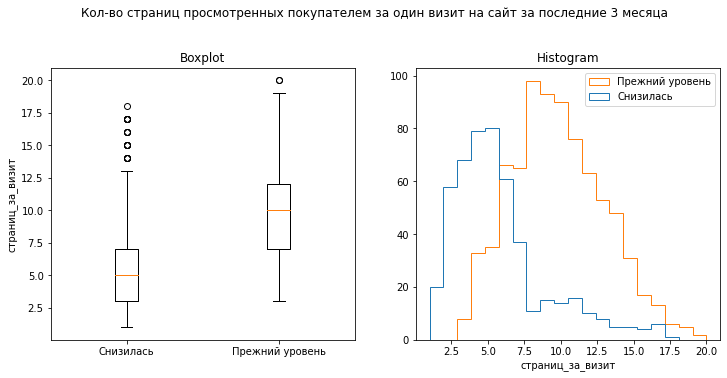

In [39]:
box_hist_plot_сompare(market_file_df, 'страниц_за_визит', 20, 'Кол-во страниц просмотренных покупателем за один визит на сайт за последние 3 месяца')

Из графиков видно, что клиенты со снижающейся активностью просматривают меньшее число страниц за визит.

Теперь рассмотрим категориальные признаки.

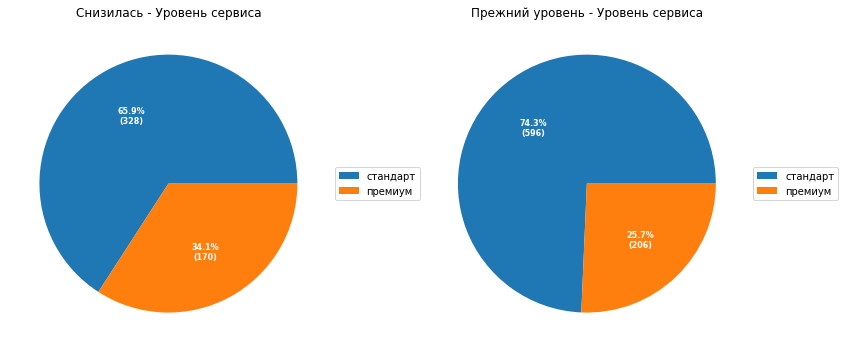

In [40]:
pie_chart_compare(market_file_df, 'тип_сервиса', 'Уровень сервиса')

Из графиков видно, что среди клиентов со снижающейся активностью доля премиальных больше чем у активных клиентов.

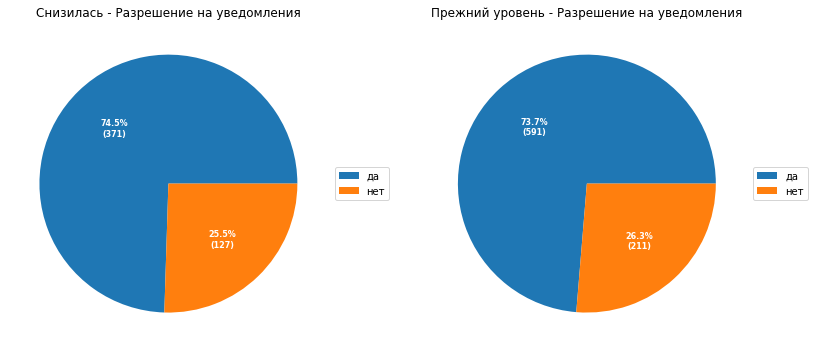

In [41]:
pie_chart_compare(market_file_df, 'разрешить_сообщать', 'Разрешение на уведомления')

Из графиков видно, что клиенты со снижающейся активностью дают чуть меньше разрешений на получение уведомлений.

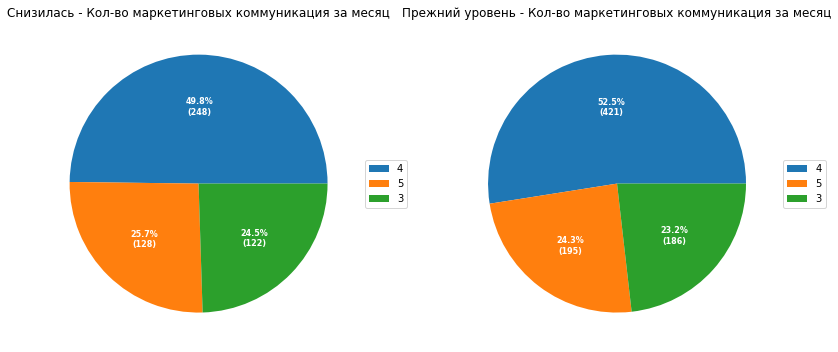

In [42]:
pie_chart_compare(market_file_df, 'маркет_актив_тек_мес', 'Кол-во маркетинговых коммуникация за месяц')

Из графиков видно, что клиенты со снижающейся активностью имеют примерно одинаковое с активными распредение по кол-ву маркетинговых коммуникаций за текущий месяц.

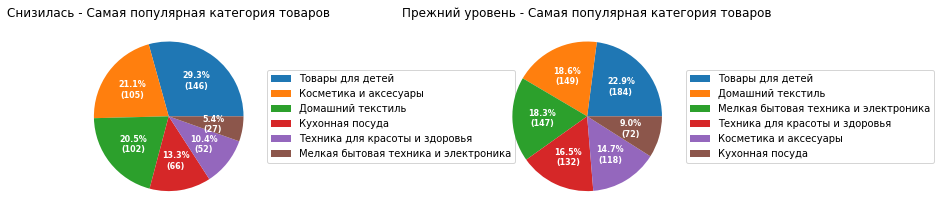

In [43]:
pie_chart_compare(market_file_df, 'популярная_категория', 'Самая популярная категория товаров')

Из графиков видно, что у клиентов со снижающейся активностью в сравнении с активными доля товаров для детей, косметики и аксесуаров, домашнего текстиля больше, а доля бытовой техники и электроники, техники для красоты и здоровья, кухонной посуды меньше.

**Вывод:** Из проведенного сравнительного анализа можно заключить, что клиенты со снижающейся активностью имеют:
* Меньшее месячное значение маркетинговых коммуникаций за последние 6 месяцев
* Большее кол-во дней с момента регистрации на сайте
* Большую долю покупок по акции от общего числа за последние 6 месяцев
* Просматривают меньшее кол-во категорий за визит
* Большее кол-во неоплаченных товаров в корзине за последние 3 месяца
* Просматривают меньшее число страниц за визит
* Большую долю премиум сервиса
* Большую долю (среди популярных категорий товаров) товаров для детей, косметики и аксесуаров, домашнего текстиля, при этом меньшую для бытовой техники и электроники, техники для красоты и здоровья, кухонной посуды.

### Отбор клиентов с покупательской активностью не менее трёх месяцев

In [44]:
ids_to_remove = market_money_df[market_money_df['выручка'] == 0]['id'].unique()
market_money_df = market_money_df[~market_money_df['id'].isin(ids_to_remove)]
market_money_df.shape

(3890, 3)

Число клиентов уменьшилось всего на 9. 

In [45]:
# Удалим клиентов с теми же id в оставшихся датафреймах
market_file_df = market_file_df[~market_file_df['id'].isin(ids_to_remove)]
market_time_df = market_time_df[~market_time_df['id'].isin(ids_to_remove)]
money_df = money_df[~money_df['id'].isin(ids_to_remove)]

## Объединение таблиц

In [46]:
# Форматируем таблицы перед объединением
market_money_df_join = market_money_df.pivot_table(index='id', columns='период', values='выручка', aggfunc='first')
market_money_df_join.columns = [f"{column}_{'выручка'}" for column in market_money_df_join.columns]
market_money_df_join = market_money_df_join.reset_index()
market_money_df_join.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1297 entries, 0 to 1296
Data columns (total 4 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           1297 non-null   int64  
 1   предыдущий_месяц_выручка     1297 non-null   float64
 2   препредыдущий_месяц_выручка  1297 non-null   float64
 3   текущий_месяц_выручка        1296 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 40.7 KB


В столбце `текущий_месяц_выручка` одно значение пропущено - это ранее удаленный выброс. Присвоим ему значение среднее по соотв. id.

In [47]:
market_money_df_join.query('текущий_месяц_выручка != текущий_месяц_выручка')

id  предыдущий_месяц_выручка  препредыдущий_месяц_выручка  \
29  215380                    6077.0                       5051.0   

    текущий_месяц_выручка  
29                    NaN

In [48]:
market_money_df_join.loc[29, 'текущий_месяц_выручка'] = (market_money_df_join.loc[29, 'предыдущий_месяц_выручка'] + market_money_df_join.loc[29, 'препредыдущий_месяц_выручка']) / 2

In [49]:
market_time_df_join = market_time_df.pivot_table(index='id', columns='период', values='минут', aggfunc='first')
market_time_df_join.columns = [f"{column}_{'минут'}" for column in market_time_df_join.columns]
market_time_df_join = market_time_df_join.reset_index()
market_time_df_join.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1297 entries, 0 to 1296
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   id                      1297 non-null   int64
 1   предыдущий_месяц_минут  1297 non-null   int64
 2   текущий_месяц_минут     1297 non-null   int64
dtypes: int64(3)
memory usage: 30.5 KB


In [50]:
# Объединим таблицы, предварительно переведя id в индексы во всех таблицах
df_1 = market_file_df.merge(market_money_df_join, on='id')
df_main = df_1.merge(market_time_df_join, on='id')
df_main.head(10)

id покупательская_активность тип_сервиса разрешить_сообщать  \
0  215349                 Снизилась     премиум                 да   
1  215350                 Снизилась    стандарт                нет   
2  215351                 Снизилась    стандарт                 да   
3  215352                 Снизилась    стандарт                нет   
4  215353                 Снизилась    стандарт                 да   
5  215354                 Снизилась    стандарт                 да   
6  215355                 Снизилась    стандарт                нет   
7  215356                 Снизилась    стандарт                 да   
8  215358                 Снизилась    стандарт                 да   
9  215360                 Снизилась     премиум                 да   

   маркет_актив_6_мес  маркет_актив_тек_мес  длительность  акционные_покупки  \
0                 4.4                     4           819               0.75   
1                 4.9                     3           539               0.14   
2                 3.2                     5           896               0.99   
3                 5.1                     3          1064               0.94   
4                 3.3                     4           762               0.26   
5                 5.1                     3           431               0.23   
6                 4.7                     4           284               0.17   
7                 4.2                     4           192               0.14   
8                 4.7                     4           450               0.13   
9                 3.9                     3           623               0.35   

    популярная_категория  средний_просмотр_категорий_за_визит  \
0       Товары для детей                                    4   
1      Домашний текстиль                                    5   
2       Товары для детей                                    5   
3       Товары для детей                                    3   
4      Домашний текстиль                                    4   
5  Косметика и аксесуары                                    2   
6       Товары для детей                                    5   
7  Косметика и аксесуары                                    2   
8      Домашний текстиль                                    4   
9        Кухонная посуда                                    3   

   неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
0                                   4               2                 5   
1                                   2               1                 5   
2                                   0               6                 4   
3                                   2               3                 2   
4                                   1               1                 4   
5                                   3               7                 2   
6                                   1               6                 4   
7                                   2               1                 3   
8                                   2               6                 4   
9                                   1               4                 7   

   предыдущий_месяц_выручка  препредыдущий_месяц_выручка  \
0                    5216.0                       4472.0   
1                    5457.5                       4826.0   
2                    6158.0                       4793.0   
3                    5807.5                       4594.0   
4                    4738.5                       5124.0   
5                    5685.0                       4503.0   
6                    3263.0                       4749.0   
7                    4146.5                       4433.0   
8                    3488.0                       4727.0   
9                    5304.5                       5555.0   

   текущий_месяц_выручка  предыдущий_месяц_минут  текущий_месяц_минут  
0                 4971.6                      12                   10  
1       

## Корреляционный анализ

Для корреляционного анализа используем матрицу корреляции библиотеки phik. 

In [42]:
%pip install phik -q

Note: you may need to restart the kernel to use updated packages.


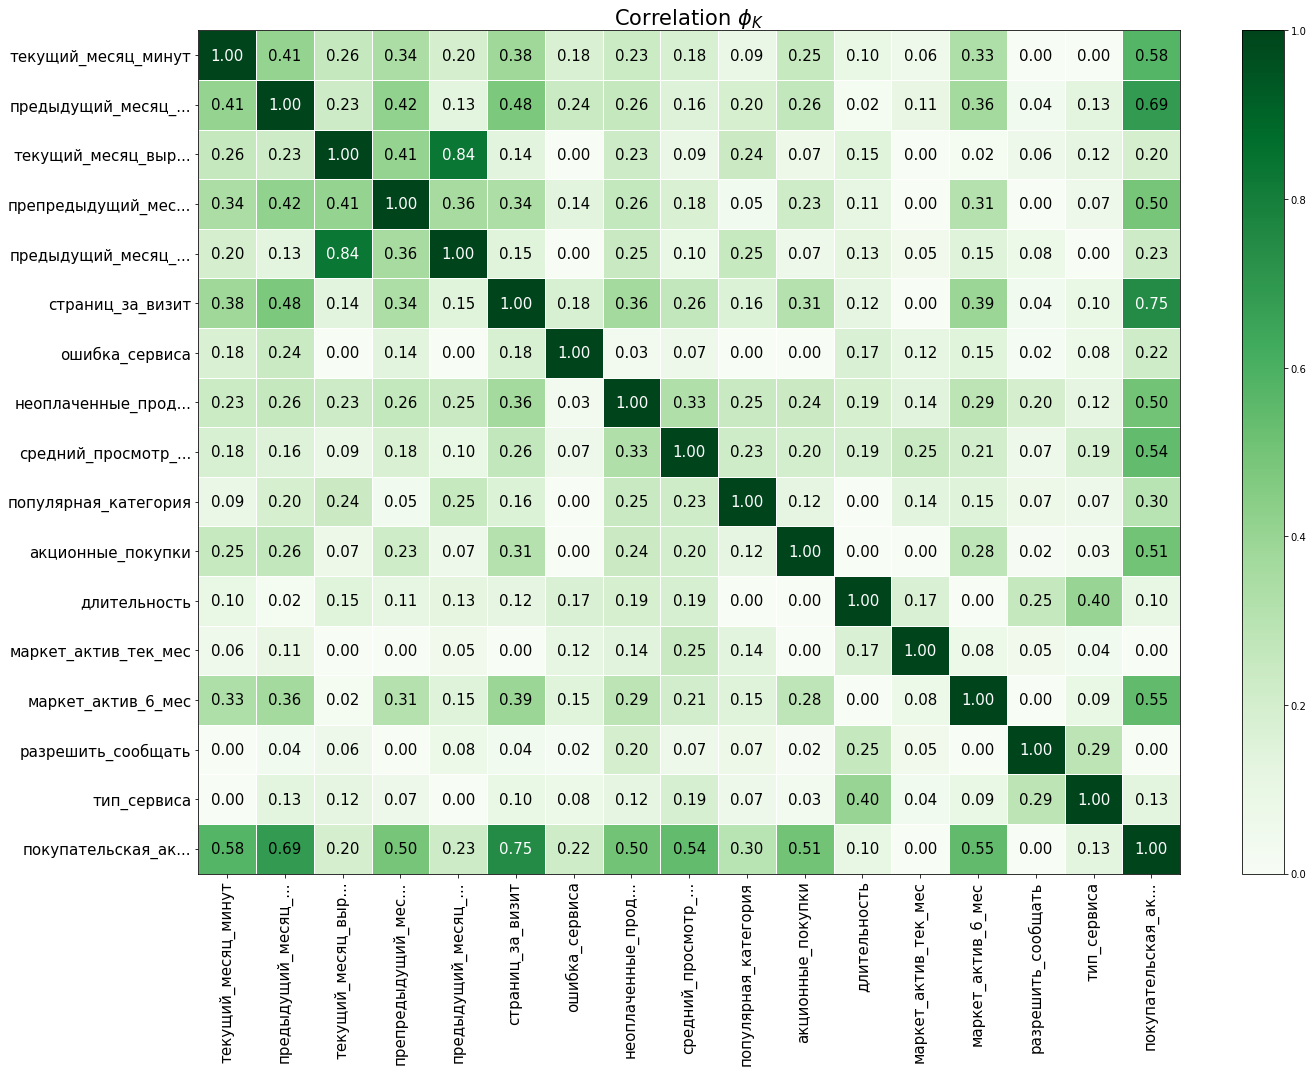

In [43]:
from phik import phik_matrix
from phik.report import plot_correlation_matrix

# Создадим список с названиями столбцов числовых (непрерывных) признаков
interval_cols = ['маркет_актив_6_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 
                 'ошибка_сервиса', 'страниц_за_визит', 'предыдущий_месяц_выручка', 'препредыдущий_месяц_выручка', 'текущий_месяц_выручка',	
                 'предыдущий_месяц_минут', 'текущий_месяц_минут']

phik_overview = phik_matrix(df_main.drop('id', axis=1), interval_cols = interval_cols)

# Визуализация матрицы корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens', 
    title=r'Correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

Если принять за значение мультиколлинеарности значения 0,9 и выше, то в исследуемом датасете ее не наблюдается.

При этом, можно заметить что с таргетом `покупательская_активность` наиболее коррелируют:
 - страниц_за_визит - 0,75
 - предыдущий_месяц_минут - 0.69
 - текущий_месяц_минут - 0.58
 - маркет_актив_6_мес - 0.55
 - акционные_покупки, неоплаченные_продукты_штук_квартал, препредыдущий_месяц_выручка- 0.5

Остальные признаки коррелирует незначительно - от 0 до 0.3

In [92]:
# Используем scatterplot matrix 
df_main_scatter = df_main.drop(['id', 'тип_сервиса', 'разрешить_сообщать', 'популярная_категория'], axis=1)

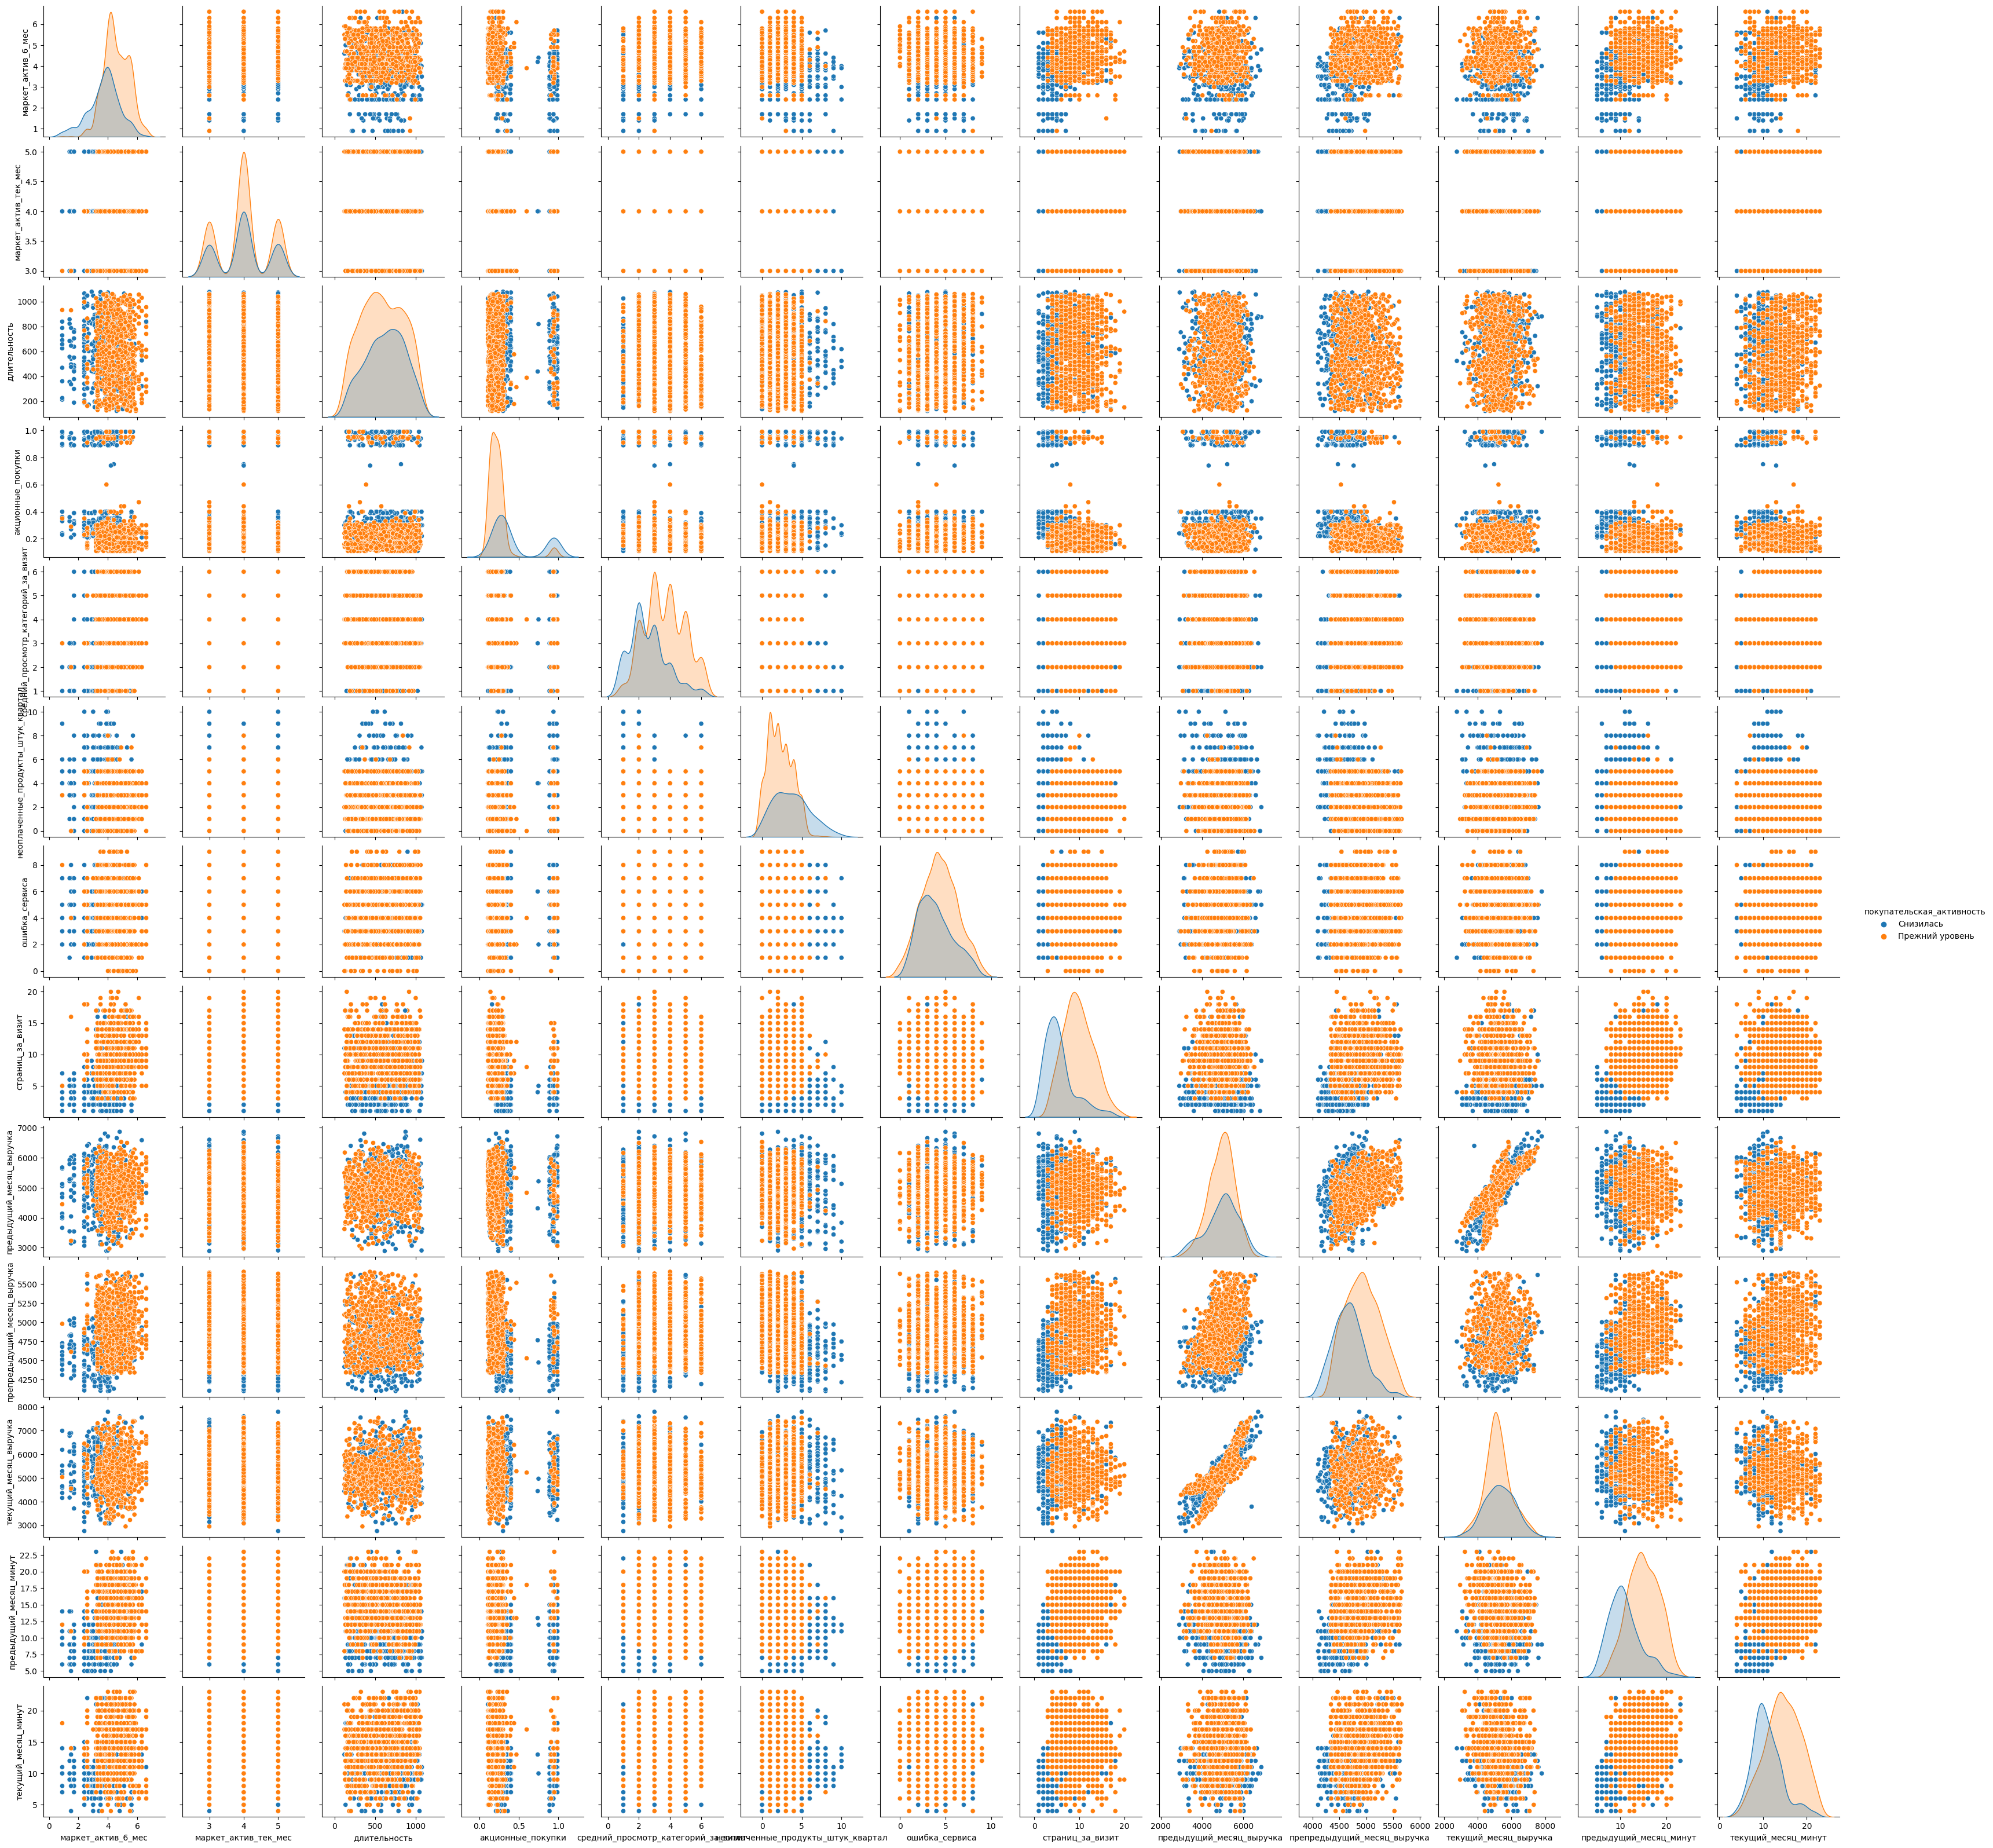

In [97]:
sns.pairplot(df_main_scatter, hue='покупательская_активность')

Из полученной матрицы рассеяния видно, что нет четкой границы между 2-мя категориями покупательской активности - каждый синий кружок (`Снизилась`) среди большего кол-ва оранжевых (`Прежний уровень`) и наоборот - свидетельство нестандартной комбинации признаков. Скорее всего линейные модели здесь покажут очень скромный результат.

## Пайплайн

### Подготовка пайплайна и выборок датасета

In [51]:
# Для обучения столбец id не нужен, поэтому сделаем его значения индексами
df_main = df_main.set_index('id')

In [52]:
# Определим колонки которые нужно масштабировать и закодировать
ohe_columns = [
    'тип_сервиса', 
    'популярная_категория'
]
ord_columns = ['разрешить_сообщать']
num_columns = [
    'маркет_актив_6_мес', 
    'маркет_актив_тек_мес', 
    'длительность', 
    'акционные_покупки', 
    'средний_просмотр_категорий_за_визит', 
    'неоплаченные_продукты_штук_квартал',
    'ошибка_сервиса',
    'страниц_за_визит',
    'предыдущий_месяц_выручка',
    'препредыдущий_месяц_выручка',
    'текущий_месяц_выручка',
    'предыдущий_месяц_минут',
    'текущий_месяц_минут'
]

RANDOM_STATE = 42
TEST_SIZE = 0.25

# Разбиение датасета на выборки (с учетом дисбаланса класса)
X = df_main.drop('покупательская_активность', axis=1)
y = df_main['покупательская_активность']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
    
# Кодирование целевого признака
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [53]:
# Посмотрим как закодировался таргет
label_encoder.inverse_transform([0, 1])

array(['Прежний уровень', 'Снизилась'], dtype=object)

In [54]:
# Определим пайплайн предобработки данных
ohe_pipe = Pipeline(
    [
        (
            'ohe',
            OneHotEncoder(drop='first', sparse=False)
        )
    ]
)

ord_pipe = Pipeline(
    [
        (
            'ord',
            OrdinalEncoder(categories=[['да', 'нет']])
        )  
    ]    
)

data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

### Итоговый пайплайн

Исследуем 4 модели (*LogisticRegression*, *KNeighborsClassifier*, *DecisionTreeClassifier*, *SVC*) с одним/двумя гиперпараметром для каждой. В кач-ве метрики используется *ROC-AUC* (или площадь под roc-кривой), которая позволяет оценивать модель при различных порогах классификации и подходит для бинарной классификации с несбалансированным таргетом.

In [58]:
# Определим итоговый пайплайн
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression(random_state=RANDOM_STATE))
])

# Определим словарь гиперпараметров (с вариацией масштабирования и моделей)
param_grid = [
    # LogisticRegression
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
            penalty='l1'
        )],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), RobustScaler()]
    },
    # KNeighborsClassifier
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,5),
        'preprocessor__num': [StandardScaler(), RobustScaler()]
    },
    # DecisionTreeClassifier
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,5),
        'models__max_features': range(2,5),
        'preprocessor__num': [StandardScaler(), RobustScaler()]
    },
    # SVC
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), RobustScaler()]
    },
]

# Для подбора гиперпараметров используем случайный поиск
rs = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rs.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', rs.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', rs.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['тип_сервиса',
                                                   'популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(categories=[['да',
                                                                                               'нет']]))]),
                                                  ['разрешить_сообщ

**Вывод:** Лучшей моделью оказалась SVC-модель (метод опорных векторов) со значением C ('сила' модели) равным 4 и методом масштабирования *RobustScaler*.  

In [60]:
probabilities_one = rs.predict_proba(X_test)[:, 1]
print(f'Значение метрики ROC-AUC на тестовой выборке: {roc_auc_score(y_test, probabilities_one)}') 

Значение метрики ROC-AUC на тестовой выборке: 0.919073984914139


Значение метрики для тестовой выборки составило 91% - неплохой результат.

## Анализ важности признаков

In [47]:
%pip install shap -q

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [48]:
import shap

In [109]:
# Закодируем и масштабируем признаки для модели
encoder = OneHotEncoder(drop='first', sparse=False)
ord_encoder = OrdinalEncoder(categories=[['да', 'нет']])
scaler = RobustScaler()

df_train_ohe = pd.DataFrame(encoder.fit_transform(X_train[ohe_columns]), columns=encoder.get_feature_names())
df_train_ord = pd.DataFrame(ord_encoder.fit_transform(X_train[ord_columns]), columns=ord_columns)
df_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[num_columns]), columns=num_columns)
X_train_df = pd.concat([df_train_scaled, df_train_ohe, df_train_ord], axis=1)
X_train_df.head()

маркет_актив_6_мес  маркет_актив_тек_мес  длительность  акционные_покупки  \
0            0.923077                   0.0     -0.255657          -0.692308   
1            0.615385                   0.0     -1.016514          -0.076923   
2            0.000000                   1.0      0.935780          -0.538462   
3           -0.461538                  -1.0      1.082569          -0.461538   
4           -0.384615                   1.0      0.194495           1.230769   

   средний_просмотр_категорий_за_визит  неоплаченные_продукты_штук_квартал  \
0                                 -0.5                            0.666667   
1                                  0.5                            1.000000   
2                                  1.0                           -0.333333   
3                                  0.5                            0.333333   
4                                  0.0                            1.666667   

   ошибка_сервиса  страниц_за_визит  предыдущий_месяц_выручка  \
0        1.000000          1.333333                  0.174009   
1       -0.666667         -0.833333                  1.528084   
2       -0.333333          0.500000                 -0.990639   
3        0.000000          0.166667                  0.132709   
4        0.000000         -0.333333                  0.926762   

   препредыдущий_месяц_выручка  текущий_месяц_выручка  предыдущий_месяц_минут  \
0                    -0.973361               0.822467                    1.12   
1                    -0.461066              -1.355213                   -0.32   
2                    -0.401639              -1.346696                    0.00   
3                     0.711066               0.056535                    0.00   
4                     0.086066               1.849192                    0.00   

   текущий_месяц_минут  x0_стандарт  x1_Косметика и аксесуары  \
0            -1.166667          1.0                       0.0   
1             0.000000          1.0                       0.0   
2            -0.500000          1.0                       0.0   
3            -0.500000          0.0                       0.0   
4            -0.666667          1.0                       0.0   

   x1_Кухонная посуда  x1_Мелкая бытовая техника и электроника  \
0                 0.0                                      1.0   
1                 0.0                                      0.0   
2                 0.0                                      1.0   
3                 0.0                                      0.0   
4                 1.0                                      0.0   

   x1_Техника для красоты и здоровья  x1_Товары для детей  разрешить_сообщать  
0                                0.0                  0.0                 0.0  
1                                1.0                  0.0                 0.0  
2                                0.0                  0.0                 0.0  
3                                0.0                  0.0                 0.0  
4                                0.0                  0.0                 0.0

In [110]:
# Сделаем тоже самое для тестовой выборки
df_test_ohe = pd.DataFrame(encoder.fit_transform(X_test[ohe_columns]), columns=encoder.get_feature_names())
df_test_ord = pd.DataFrame(ord_encoder.fit_transform(X_test[ord_columns]), columns=ord_columns)
df_test_scaled = pd.DataFrame(scaler.fit_transform(X_test[num_columns]), columns=num_columns)
X_test_df = pd.concat([df_test_scaled, df_test_ohe, df_test_ord], axis=1)
X_test_df.head()

маркет_актив_6_мес  маркет_актив_тек_мес  длительность  акционные_покупки  \
0                 1.2                   1.0     -0.422652           5.153846   
1                 0.0                  -1.0      0.627072          -0.153846   
2                -0.2                   1.0     -0.486188          -0.307692   
3                 0.5                   1.0     -0.809392           0.000000   
4                -0.6                   0.0     -0.035912           1.230769   

   средний_просмотр_категорий_за_визит  неоплаченные_продукты_штук_квартал  \
0                                 -1.0                           -0.666667   
1                                  0.0                            0.000000   
2                                  0.0                           -0.666667   
3                                 -1.0                            0.000000   
4                                 -0.5                            0.333333   

   ошибка_сервиса  страниц_за_визит  предыдущий_месяц_выручка  \
0            -2.0         -0.166667                 -0.287344   
1             0.0         -0.500000                  0.463878   
2             0.5          1.000000                  0.082564   
3            -0.5         -0.833333                 -0.168930   
4            -1.5         -0.666667                 -0.912004   

   препредыдущий_месяц_выручка  текущий_месяц_выручка  предыдущий_месяц_минут  \
0                     0.841410               0.013789                     0.4   
1                     0.244493               0.011372                    -0.2   
2                     1.255507              -0.258686                     0.8   
3                     0.207048               0.005462                    -0.2   
4                    -1.101322              -1.260029                    -0.4   

   текущий_месяц_минут  x0_стандарт  x1_Косметика и аксесуары  \
0             1.000000          1.0                       0.0   
1            -0.714286          0.0                       0.0   
2             0.000000          0.0                       1.0   
3             0.142857          1.0                       0.0   
4            -0.142857          1.0                       1.0   

   x1_Кухонная посуда  x1_Мелкая бытовая техника и электроника  \
0                 0.0                                      0.0   
1                 0.0                                      0.0   
2                 0.0                                      0.0   
3                 0.0                                      0.0   
4                 0.0                                      0.0   

   x1_Техника для красоты и здоровья  x1_Товары для детей  разрешить_сообщать  
0                                1.0                  0.0                 0.0  
1                                0.0                  0.0                 0.0  
2                                0.0                  0.0                 0.0  
3                                0.0                  1.0                 0.0  
4                                0.0                  0.0                 0.0

In [112]:
clf_svc = SVC(kernel='rbf', C=4, random_state=42, probability=True)
clf_svc.fit(X_train_df, y_train)

SVC(C=4, probability=True, random_state=42)

Поскольку лучшей моделью является модель МОВ с нелинейным ядром rbf, то для дальнейшей работы нам необходимо использовать KernelExplainer. Для сокращения времени расчета (так для 972 строк датасета время расчета "shap_values" составляет 48 часов) используем метод *shap.kmeans(data, K)* (ссылка на документацию где дается такая рекомендация - https://shap-lrjball.readthedocs.io/en/latest/generated/shap.KernelExplainer.html):

>  *For small problems this background dataset can be the whole training set, but for larger problems consider using a single reference value or using the kmeans function to summarize the dataset.*

In [52]:
X_train_df_summary = shap.kmeans(X_train_df, 10)
# Примечание - при значении 100 результаты не изменились

In [53]:
explainer = shap.KernelExplainer(clf_svc.predict_proba, X_train_df_summary)

In [54]:
shap_values = explainer(X_test_df)

  0%|          | 0/325 [00:00<?, ?it/s]

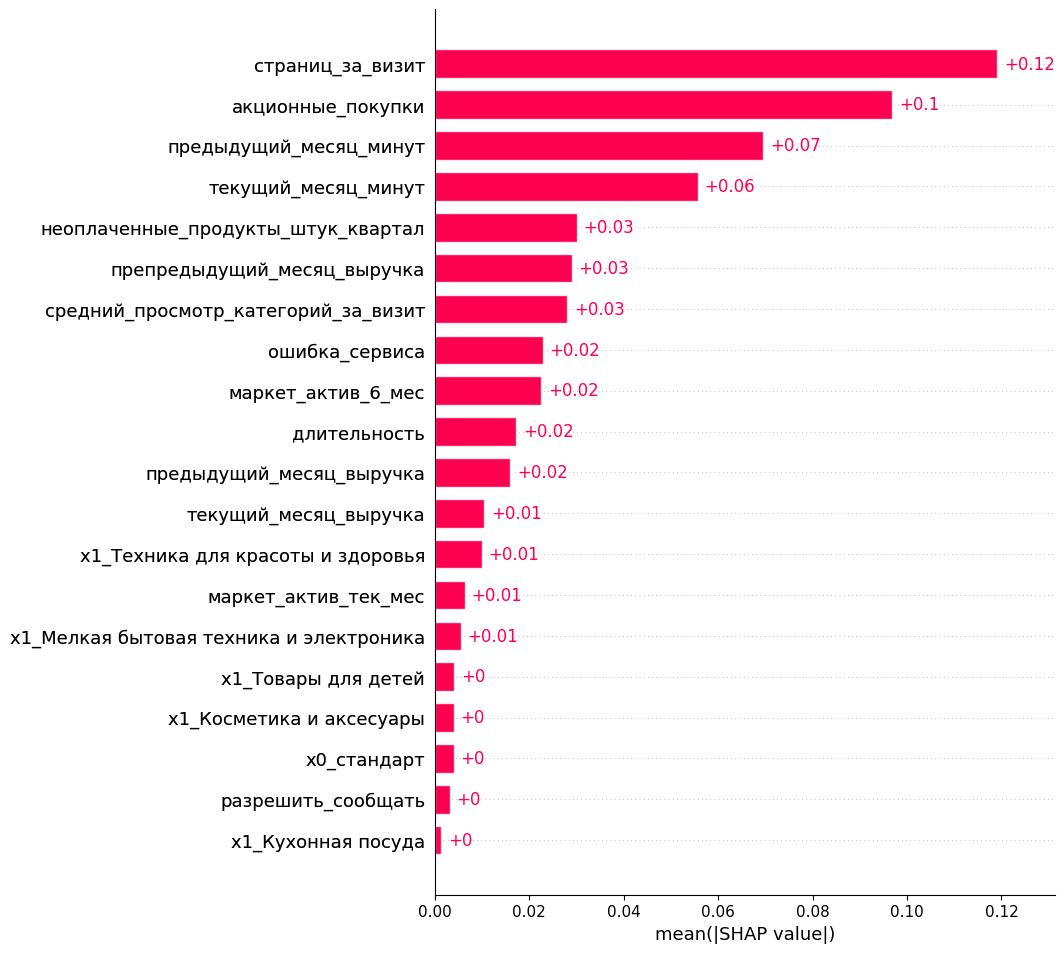

In [95]:
shap.plots.bar(shap_values, max_display=20)

На столбчатой SHAP-диаграммы можно видеть, что 
* топ-5 значимыми признаками являются (в порядке убывания) `страниц_за_визит`, `акционные_покупки`,  `предыдущий_месяц_минут`, `текущий_месяц_минут`, `неоплаченные_продукты_штук_квартал` (`предыдущий_месяц_выручка`, `средний_просмотр_категорий_за_визит`); 

* менее значимыми оказались признаки: `текущий_месяц_выручка`, `маркет_актив_тек_мес`, `тип сервиса`, `разрешить_сообщать`. 

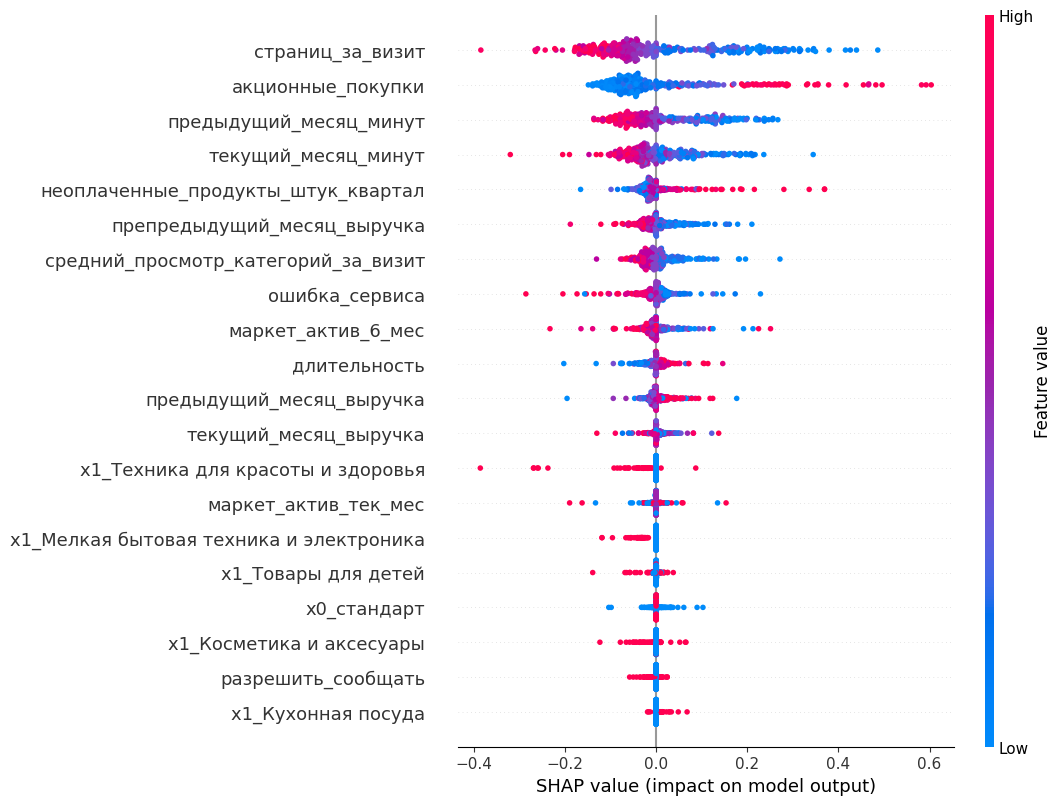

In [80]:
shap.plots.beeswarm(shap_values, max_display=20)

Из графика SHAP-beeswarm видно, что (для топ-5 признаков, названных ранее):
* Чем больше значения признаков `страниц_за_визит`, `предыдущий_месяц_минут`, `текущий_месяц_минут`, `препредыдущий_месяц_выручка`, `средний_просмотр_категорий_за_визит`, тем меньше SHAP-значения объектов - если у наблюдения высокие значения этих признаков, то у него высокая вероятность принадлежности к классу 0 или `Прежний уровень`.

* Чем больше значения признаков `акционные_покупки` и `неоплаченные_продукты_штук_квартал`, тем больше SHAP-значения объектов - если у наблюдения высокие значения этих признаков, то у него высокая вероятность принадлежности к классу 1 или `Снизилась`.

##  Сегментация покупателей

Для исследования отберем сегмент покупателей, приобретающих только технику - это примерно 28% от всех категорий интернет-магазина. Предварительно пересоберем данные для последущего анализа. 

In [113]:
money_df = money_df.set_index('id')

In [114]:
df_full = df_main.join(money_df)

In [162]:
# Подготовим данные для расчета моделью вероятности снижения активности
df_full_ohe = pd.DataFrame(encoder.fit_transform(df_full[ohe_columns]), columns=encoder.get_feature_names())
df_full_ord = pd.DataFrame(ord_encoder.fit_transform(df_full[ord_columns]), columns=ord_columns)
df_full_scaled = pd.DataFrame(scaler.fit_transform(df_full[num_columns]), columns=num_columns)
X_full_df = pd.concat([df_full_ohe, df_full_ord, df_full_scaled], axis=1)

In [146]:
probas = clf_svc.predict_proba(X_full_df)

In [148]:
df_full['predict_proba'] = probas[:,1]
df_full['predict_proba_cat'] = pd.cut(df_full['predict_proba'], bins=[-float('inf'), 0.6, float('inf')], labels=['<0.6', '>=0.6'])

In [151]:
# Выделим необходимый сегмент
df_segment = df_full.query('средний_просмотр_категорий_за_визит == [1, 2] and популярная_категория == ["Техника для красоты и здоровья", "Мелкая бытовая техника и электроника"]')

Выберем значение порога равным 0.6

<AxesSubplot:title={'center':'Прибыль'}, xlabel='predict_proba_cat'>

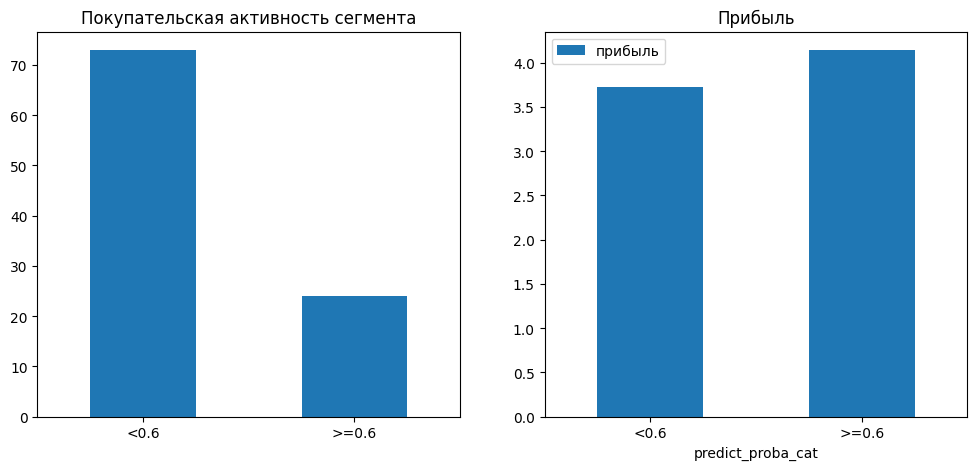

In [161]:
# Посмотрим на соотношение покупательской активности сегмента и приносимый прибыли 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

axes[0].set_title('Покупательская активность сегмента')
df_segment['predict_proba_cat'].value_counts().plot(kind='bar', rot=0, ax=axes[0])

axes[1].set_title('Прибыль')
df_segment.pivot_table(index='predict_proba_cat', values='прибыль', aggfunc='median').plot(kind='bar', rot=0, ax=axes[1])

Клиентов с высокой вероятностью снижения покупательской активности меньше, при этом отдельно взятый клиент из данной группы приносит несколько большую прибыль. Далее сравним группы по наиболее значимым признакам. 

<AxesSubplot:xlabel='predict_proba_cat'>

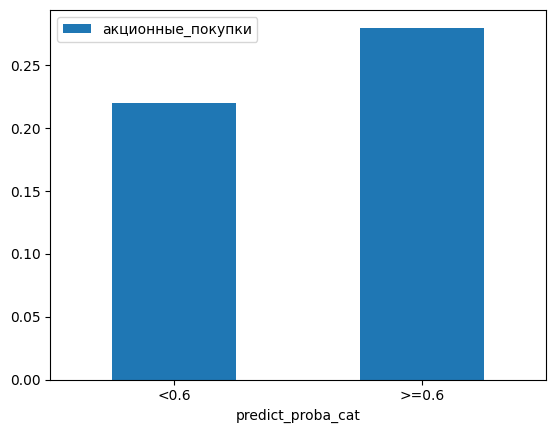

In [163]:
# Посмотрим на соотношение покупок по акции
df_segment.pivot_table(index='predict_proba_cat', values='акционные_покупки', aggfunc='median').plot(kind='bar', rot=0)

Можно видеть, что бОльшая доля акционных покупок характерна для клиентов с высокой вероятностью снижения покупательской активности. 

<AxesSubplot:xlabel='predict_proba_cat'>

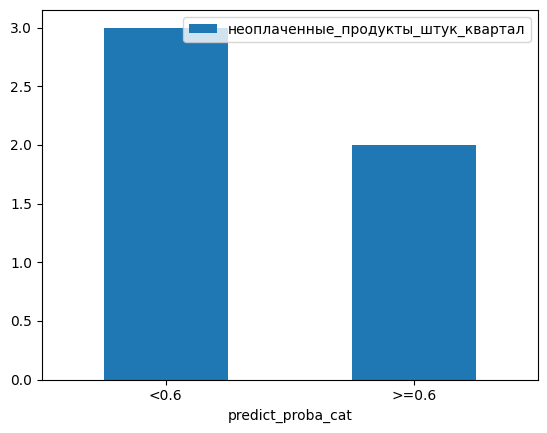

In [166]:
# Соотношение по неоплаченным продуктам
df_segment.pivot_table(index='predict_proba_cat', values='неоплаченные_продукты_штук_квартал', aggfunc='median').plot(kind='bar', rot=0)

Можно видеть, что меньшее число неоплаченных товаров в корзине имеют клиенты с высокой вероятностью снижения покупательской активности. 

<AxesSubplot:xlabel='predict_proba_cat'>

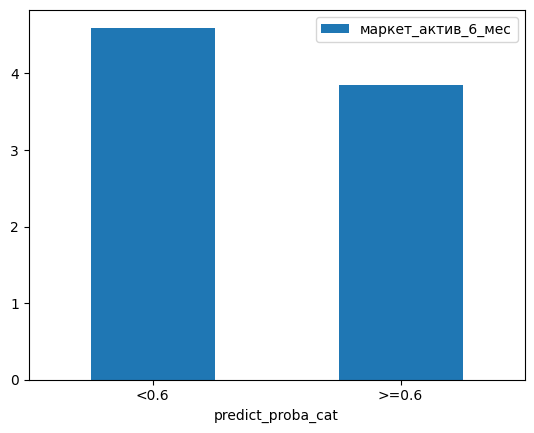

In [167]:
# Соотношение по кол-ву маркетинговых коммуникаций за последние 6 месяцев
df_segment.pivot_table(index='predict_proba_cat', values='маркет_актив_6_мес', aggfunc='median').plot(kind='bar', rot=0)

Можно видеть, что меньшее число маркетинговых коммуникаций за последние 6 месяцев имеют клиенты  клиенты с высокой вероятностью снижения покупательской активности.  

<AxesSubplot:xlabel='predict_proba_cat'>

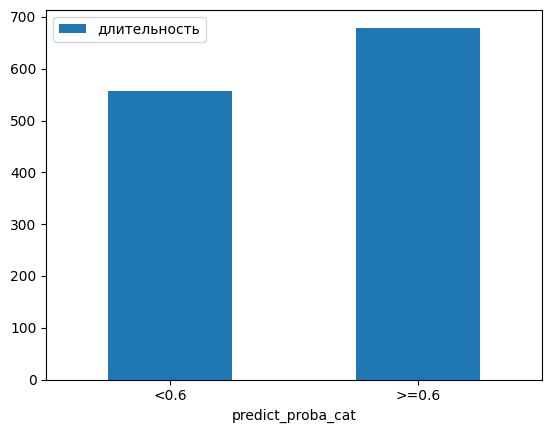

In [168]:
# Соотношение по кол-ву дней с момента регистрации пользователя
df_segment.pivot_table(index='predict_proba_cat', values='длительность', aggfunc='median').plot(kind='bar', rot=0)

Можно видеть, что более "старые" пользователи это клиенты с высокой вероятностью снижения покупательской активности.  

На основании ранее изученного, можно предложить следущее: 

* Поскольку клиенты сегмента с высокой вероятностью снижения покупательской активности совершают больше покупок по акции, то можно предположить, что сама система проведения акций не подталкивает клиентов к повторной и более длительной активности на сайте. Возможно имеет смысл прибегнуть к другой системе, например, к бонусной программе - вместо скидки клиент получает баллы, которые можно потратить при следующей покупке. Поскольку их можно использовать при следующей покупке, то клиент, вероятнее всего, вновь вернется на сайт. Так например, при покупке определенного вида техники можно начислять бонусы на покупку дополнительных комплектующих к ней, техники от того же производителя и т.д. 

* Стоит также отметить, что клиенты сегмента с низкой вероятностью снижения покупательской активности чаще просто оставляют товар в корзине и не покупает его. Наиболее простой вариант - это отправка push-уведомлений для пользователей с включенными уведомлениями (в нашем датасете таковых большинство - 70%) и email-рассылки для напоминания клиентам о незавершенных покупках или предложениями более дешевых аналогов выбранного вида техники и т.д. Однако тут стоит адекватно выбирать частоту отправки повторных уведомлений и писем (тем, кто так и не купил товар из корзины), чтобы не вызвать раздражения пользователя избыточными оповещениями. Тут стоит также упомянуть, что клиенты с высокой вероятностью снижения покупательской активности имеют меньшее число маркетинговых коммуникаций - поэтому стоит обратить внимание на их увеличение.

* Возможно также проведение программ лояльности направленных на стимулирование клиентов к совершению покупок на сайте. Так например, участнику программы при вступлении выдается вступительный бонус, а затем в зависимости от суммы покупок за определенный период или при покупке техники определенных брендов, присваивается определенный статус, который позволяет получить более выгодные бонусы, скидки, ранний доступ к техническим новинкам т.д. Дополнительно это также позволит больше узнать о поведении клиентов и более точно персонифицировать предложение для них.   

## Общий вывод

Интернет-магазину "В один клик" с целью удержания постоянных клиентов на основании имеющихся групп данных (коммуникации с клиентом, продуктовое поведение клиента, финансовое поведение клиента, поведение клиента на сайте) было необходимо разработать модель, позволяющую предсказывать вероятность снижения покупательской активности клиентов в следующие 3 месяца. Далее, на основании данных о прибыльности клиентов и разработанной модели, для выделенного сегмента покупателей необходимо было разработать персонализированные предложения.

Предварительно была произведна предобработка данных - пропусков и явных дубликатов выявлено не было, к необходимым форматам были приведены те группы данных для которых это было необходимо, выявлены и устранены неявные дубликаты, а также унифицированы названия столбцев в датасетах.

Для поиска лучшей модели были использованы пайплайны - путем перебора методов масштабирования и моделей с использованием автоматизированного рандомизированного поиска лучших параметров (RandomizedSearchCV) была определена наилучшая модель - SVC с ядром RBF, со значением C=4. 

Для выделенного сегмента (клиенты покупающие только технику) было предложено: изменить акционную систему (например, попробовать бонусные программмы), подталкивать клиентов к покупке выбранных, но не оплаченных товаров из корзины путем отправки им соответствующих уведомлений, увеличение маркетинговой активности и проведением программы лояльности.